In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyfits as fits

In [2]:
filename = 'muse_scipost_N_SN2009bb_DATACUBE_FINAL_IFU_001_zap.fits'
filepath = 'data/'

In [3]:
data = fits.open(filepath+filename)

In [4]:
image = data[1].data
header = data[1].header
del data

In [5]:
image.shape

(3681, 321, 320)

#### Building the base spectrum

In [6]:
# spectral wavelengths
CRVAL3 = float(header["CRVAL3"])
CRPIX3 = float(header["CRPIX3"])
CUNIT3 = header["CUNIT3"]
CD31 = float(header["CD3_1"])
CD32 = float(header["CD3_2"])
CD33 = float(header["CD3_3"])
NAXIS3 = int(header["NAXIS3"])
lambdas = np.array(CRVAL3 + CD33 * (np.arange(NAXIS3) - CRPIX3))

In [7]:
lambdas

array([ 4748.47607422,  4749.72607422,  4750.97607422, ...,  9345.97607422,
        9347.22607422,  9348.47607422])

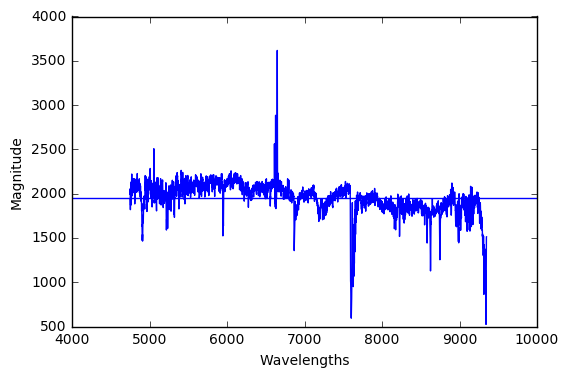

In [55]:
plt.plot(lambdas, image[:, 215, 69])
plt.axhline(y = np.mean(image[:, 215, 69]))
plt.ylabel('Magnitude')
plt.xlabel('Wavelengths')

In [54]:
np.mean(image[:, 215, 69])

1945.5895

In [9]:
lambdas[np.argmax(image[:, 215, 69])]

6648.47607421875

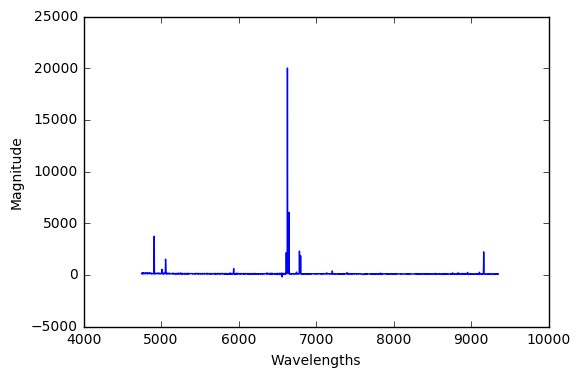

In [10]:
plt.plot(lambdas, image[:, 150, 150])
plt.ylabel('Magnitude')
plt.xlabel('Wavelengths')

In [11]:
lambdas[np.argmax(image[:, 150, 150])]

6629.72607421875

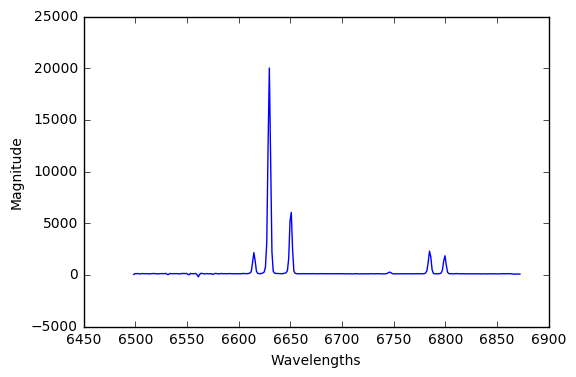

In [12]:
plt.plot(lambdas[1400:1700], image[:, 150, 150][1400:1700])
plt.ylabel('Magnitude')
plt.xlabel('Wavelengths')

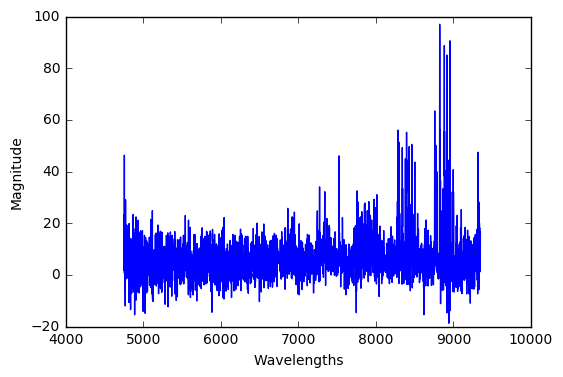

In [13]:
plt.plot(lambdas, image[:, 250, 250])
plt.ylabel('Magnitude')
plt.xlabel('Wavelengths')

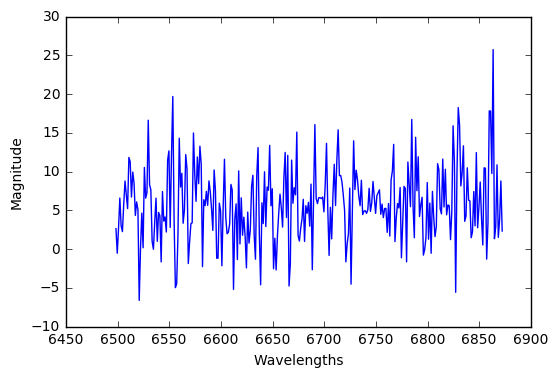

In [14]:
plt.plot(lambdas[1400:1700], image[:, 250, 250][1400:1700])
plt.ylabel('Magnitude')
plt.xlabel('Wavelengths')

In [15]:
#Building the template
#Need to find the closest value of the wavelength to the theoretical value
H_a = 6562.8
H_b = 4861.3
variables = [H_a, H_b]
base_spectra = np.zeros(len(lambdas))
for var in variables:
    arg_var = np.argmin(np.abs(lambdas - var))
    base_spectra[arg_var] = 1.

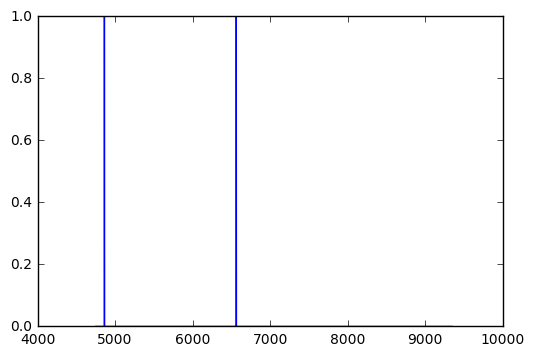

In [16]:
plt.plot(lambdas, base_spectra)

In [17]:
test_spectra = image[:, 215, 69]
test_spectra2 = image[:, 150, 150]
test_spectra3 = image[:, 250, 250]

In [18]:
# Function to clean up the spectrum
# Variables is the elements we are focusing on
def clean_spectra_func(spectra, range_ang=50):
    """
    spectra : spectra array
    range_ang : filtering range around the  desired wavelengths +ve and -ve
    """
    clean_spectra = np.zeros(len(spectra))
    for var in variables:
        min_bound = np.argmin(np.abs(lambdas - (var-range_ang)))
        max_bound = np.argmin(np.abs(lambdas - (var+range_ang)))
        # Filtering in the bounds
        temp_var = spectra[min_bound:max_bound]
        # Finding the max_value
        max_value_var = np.max(temp_var)
        max_value_arg = np.argmax(temp_var)
        # Fixing the value in the clean spectrum
        clean_spectra[min_bound + max_value_arg] = max_value_var
    return clean_spectra

In [19]:
clean_spectra = clean_spectra_func(test_spectra3, range_ang=70)

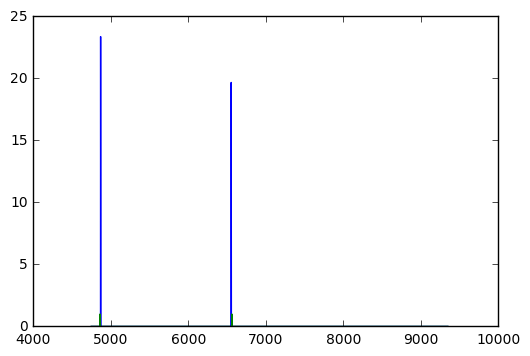

In [20]:
plt.plot(lambdas, clean_spectra)
plt.plot(lambdas, base_spectra)

In [21]:
#Function for template matching
def template_matching(spectra, max_shift=70):
    """
    max_shift: Maximum shift in each direction
    """
    clean_spectra = clean_spectra_func(spectra, range_ang=70)
    possible_values = []
    for var in variables:
        min_bound = np.argmin(np.abs(lambdas - (var-max_shift)))
        max_bound = np.argmin(np.abs(lambdas - (var+max_shift)))
        # Filtering in the bounds
        temp_var = clean_spectra[min_bound:max_bound]
        # Finding the max_value
        max_value_var = np.max(temp_var)
        max_value_arg = np.argmax(temp_var)
        possible_values.append((lambdas[min_bound + max_value_arg] - var)/var)
    return np.max(possible_values)

In [22]:
# Filtering the image. Removing 10 points on each side 
filt_image = image[:, 10:-10, 10:-10]

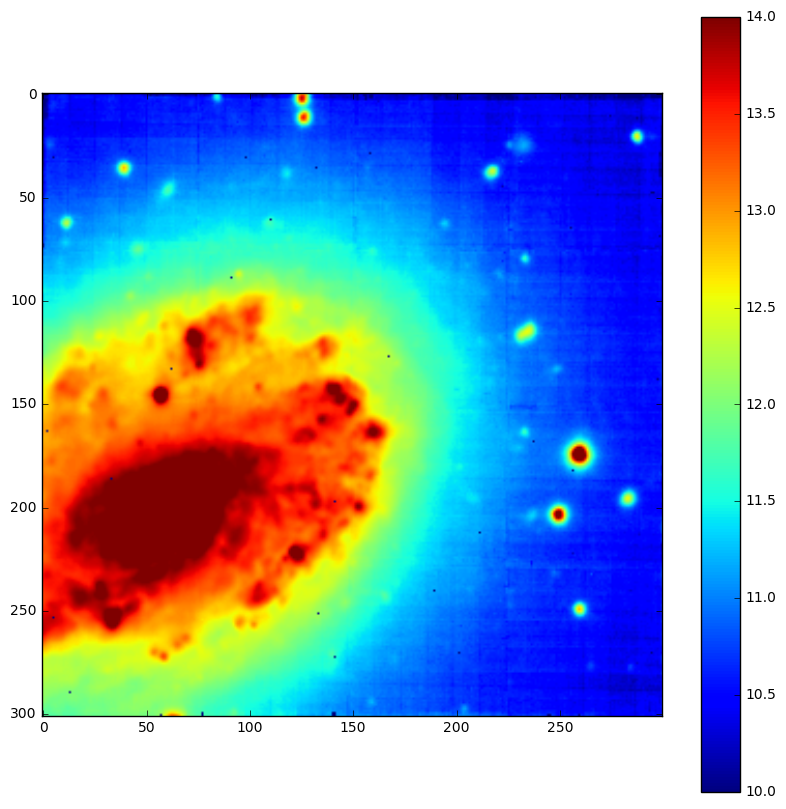

In [253]:
image2D = np.sum(filt_image, axis=0)
image2D[np.invert(np.isfinite(image2D))] = 0
image2D = np.arcsinh(image2D)
fig, ax = plt.subplots(figsize = (10, 10))
color = ax.imshow(image2D, clim = (10, 14));
fig.colorbar(color);

In [23]:
# Creating an image
red_shift_image = np.zeros((filt_image.shape[1], filt_image.shape[2]))

In [24]:
from tqdm import tqdm

In [25]:
for i in tqdm(range(filt_image.shape[1])):
    for j in range(filt_image.shape[2]):
        spectra = filt_image[:, i,  j]
        shift = template_matching(spectra, max_shift=200)
        red_shift_image[i, j] = shift

100%|██████████| 301/301 [00:11<00:00, 24.61it/s]


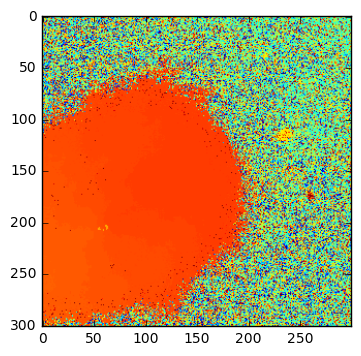

In [26]:
plt.imshow(red_shift_image)

In [27]:
from scipy.stats import threshold

In [28]:
red_shift_image_new = threshold(red_shift_image, 0.008)

In [29]:
red_shift_image[175, 11]

0.0096263902935865512

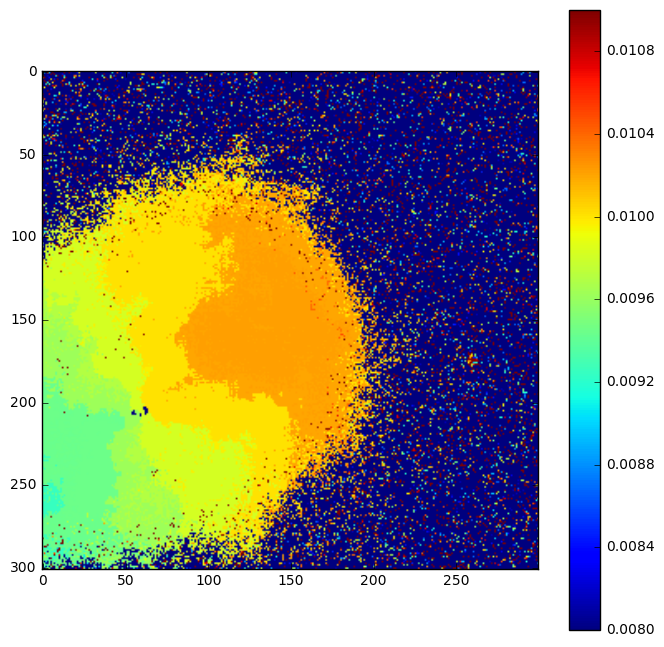

In [30]:
fig, ax = plt.subplots(figsize = (8, 8))
color = ax.imshow(red_shift_image_new, clim = (0.008, 0.011));
fig.colorbar(color)

In [31]:
template_matching(filt_image[:, 50, 250], max_shift=200)

0.0091901495934729009

In [32]:
rs_array = red_shift_image
rs_array = rs_array.flatten()

In [33]:
rs_array_2 = rs_array[rs_array>0.0075]

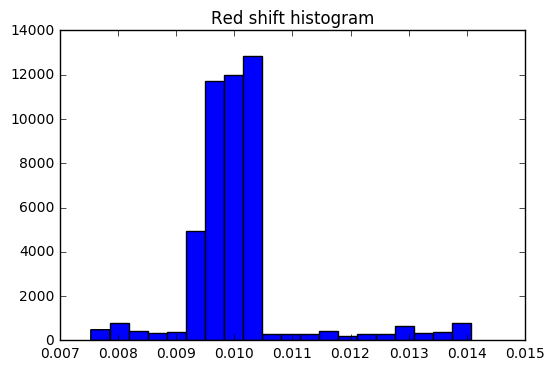

In [34]:
plt.hist(rs_array_2, bins=20)
plt.title('Red shift histogram');

#### Testing

In [43]:
red_shift_image.shape

(301, 300)

In [44]:
filt_image.shape

(3681, 301, 300)

In [45]:
new_image_cube_lamb = np.zeros(filt_image.shape)

In [46]:
for i in tqdm(range(filt_image.shape[1])):
    for j in range(filt_image.shape[2]):
        red_shift = red_shift_image[i, j]
        for k in range(filt_image.shape[0]):
            new_image_cube[k, i, j] = lambdas[k]/(1+red_shift)

100%|██████████| 301/301 [05:55<00:00,  1.06s/it]


In [47]:
# Creating an image
kred_shift_image = np.zeros((filt_image.shape[1], filt_image.shape[2]))

In [48]:
def template_matching_lambda(spectra, lambdas, max_shift=70):
    """
    max_shift: Maximum shift in each direction
    """
    clean_spectra = clean_spectra_func(spectra, range_ang=70)
    possible_values = []
    for var in variables:
        min_bound = np.argmin(np.abs(lambdas - (var-max_shift)))
        max_bound = np.argmin(np.abs(lambdas - (var+max_shift)))
        # Filtering in the bounds
        temp_var = clean_spectra[min_bound:max_bound]
        # Finding the max_value
        max_value_var = np.max(temp_var)
        max_value_arg = np.argmax(temp_var)
        possible_values.append((lambdas[min_bound + max_value_arg] - var)/var)
    return np.max(possible_values)

In [50]:
for i in tqdm(range(new_image_cube.shape[1])):
    for j in range(new_image_cube.shape[2]):
        spectra = filt_image[:, i,  j]
        lambdas_ = new_image_cube[:, i, j]
        shift = template_matching_lambda(spectra, lambdas_, max_shift=200)
        kred_shift_image[i, j] = shift

100%|██████████| 301/301 [00:53<00:00,  6.72it/s]


In [51]:
kred_shift_image_new = threshold(kred_shift_image, 0.008)

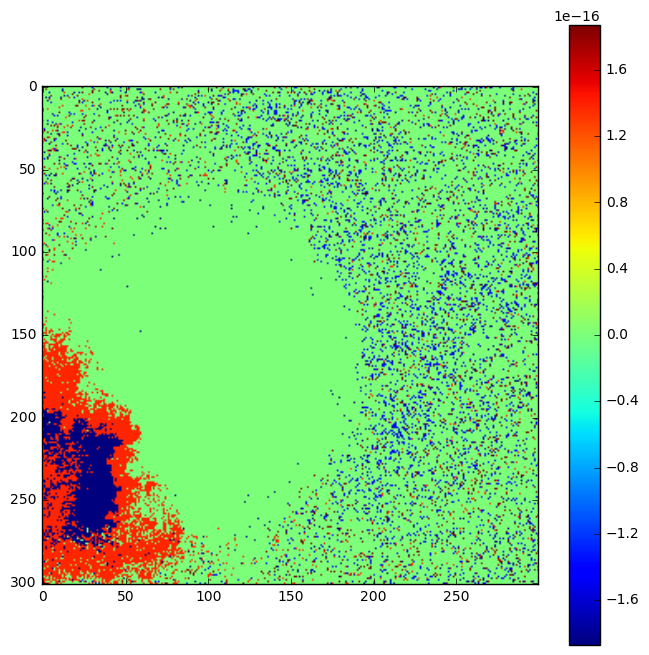

In [53]:
fig, ax = plt.subplots(figsize = (8, 8))
color = ax.imshow(kred_shift_image);
fig.colorbar(color)

In [162]:
# Saving the files
# Red shift
np.save('corrected_data/red_shift', red_shift_image)
# Corrected wavelengths
np.save('corrected_data/corr_wavelengths', new_image_cube)

In [77]:
# Correcting the magnitude
filt_image = (1 + np.mean(rs_array_2n))*filt_image

In [147]:
print "Cosmological Red Shift :", np.mean(rs_array_2n)

Cosmological Red Shift : 0.00975482586067


#### Removing emission lines

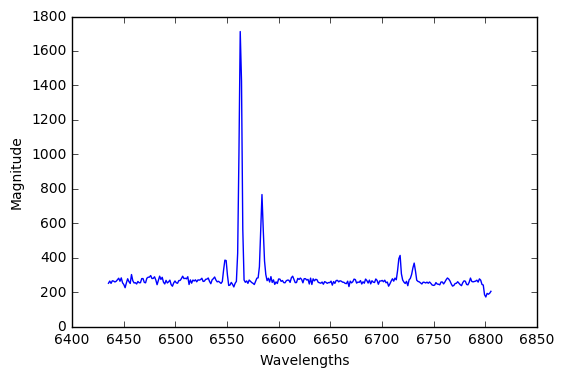

In [81]:
plt.plot(new_image_cube[:, 250, 69][1400: 1700], filt_image[:, 250, 69][1400: 1700])
plt.ylabel('Magnitude')
plt.xlabel('Wavelengths')

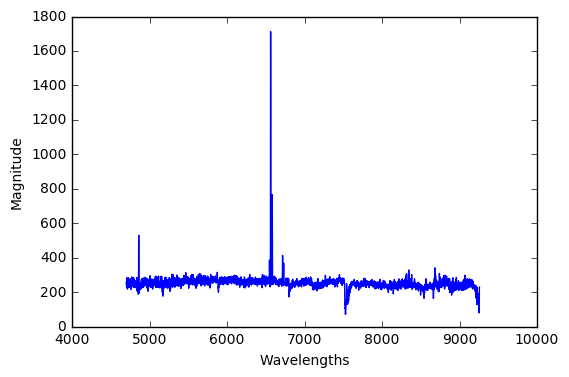

In [103]:
plt.plot(new_image_cube[:, 215, 69], filt_image[:, 215, 69])
plt.ylabel('Magnitude')
plt.xlabel('Wavelengths')

In [93]:
from scipy.signal import medfilt

In [94]:
def run_filter(spectra, filter_len=10):
    loop_size = int(len(spectra)/filter_len)
    for i in range(loop_size):
        #Checking for a peak
        mean = np.mean(spectra[i*filter_len:(i+1)*filter_len])
        max_ = np.max(spectra[i*filter_len:(i+1)*filter_len])
        print mean, max_

In [157]:
med_filt_val = medfilt(filt_image[:, 215, 169], kernel_size=11)

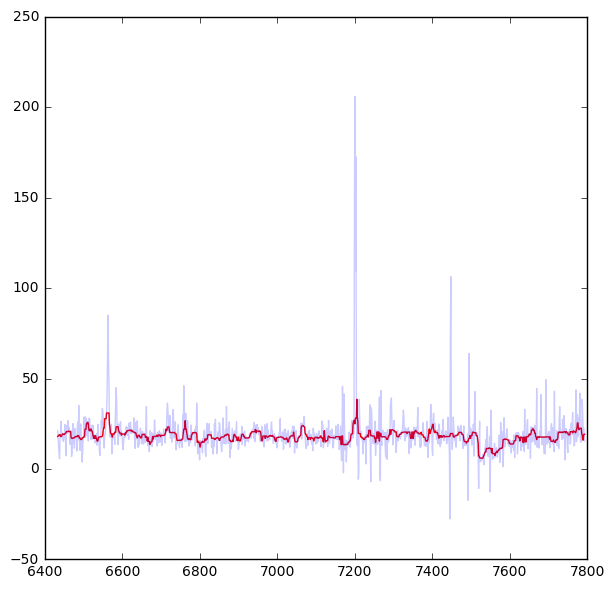

In [158]:
plt.figure(figsize=(7,7))
plt.plot(new_image_cube[:, 215, 169][1400:2500], med_filt_val[1400:2500], color='r')
#plt.plot(new_image_cube[:, 215, 69][1600:2500], medfilt(filt_image[:, 215, 69][1400:2500], kernel_size=301), color='b')
plt.plot(new_image_cube[:, 215, 169][1400:2500], filt_image[:, 215, 169][1400:2500], color='b', alpha=0.2)
# plt.ylim([0, 300])

In [159]:
new_filt_truc = np.zeros(filt_image.shape)

In [160]:
for i in tqdm(range(new_filt_truc.shape[1])):
    for j in range(new_filt_truc.shape[2]):
        new_filt_truc[:, i, j] = medfilt(filt_image[:, i, j], kernel_size=11)

100%|██████████| 301/301 [04:55<00:00,  1.09s/it]


In [161]:
np.save('corrected_data/filtered_data', new_filt_truc)

#### Secondary filtering

In [63]:
H_a = 6562.8
H_b = 4861.3
S_ = 6716.0
Na_ = 5894.0
O_3 = 5006.8
variables = [H_a, H_b, S_, Na_, O_3]
rough_res_shift = 0.0095
base_spectra_n = np.zeros(len(lambdas))
for var in variables:
    arg_var = np.argmin(np.abs(lambdas - var))
    base_spectra_n[arg_var] = 1.

In [64]:
def clean_spectra_small_func(spectra, rough_res_shift ,range_ang=20):
    """
    spectra : spectra array
    range_ang : filtering range around the  desired wavelengths +ve and -ve
    """
    clean_spectra = np.zeros(len(spectra))
    for var in variables:
        min_bound = np.argmin(np.abs(lambdas - (var+rough_res_shift*var-range_ang)))
        max_bound = np.argmin(np.abs(lambdas - (var+rough_res_shift*var+range_ang)))
        # Filtering in the bounds
        temp_var = spectra[min_bound:max_bound]
        # Finding the max_value
        max_value_var = np.max(temp_var)
        max_value_arg = np.argmax(temp_var)
        # Fixing the value in the clean spectrum
        clean_spectra[min_bound + max_value_arg] = max_value_var
    return clean_spectra

In [65]:
clean_spectra = clean_spectra_small_func(test_spectra2, rough_res_shift)

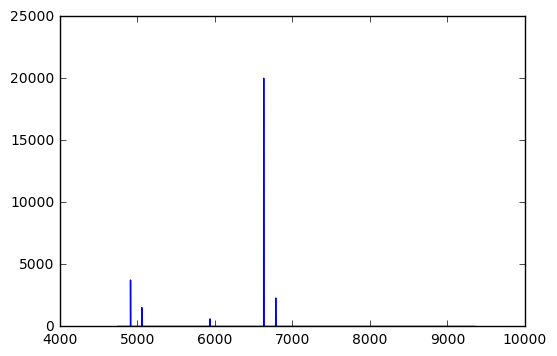

In [66]:
plt.plot(lambdas, clean_spectra)

In [67]:
from heapq import nsmallest

In [68]:
def template_matching_small(spectra, rough_res_shift, max_shift=60):
    """
    max_shift: Maximum shift in each direction
    """
    clean_spectra = clean_spectra_small_func(spectra, rough_res_shift, range_ang=20)
    possible_values = []
    for var in variables:
        min_bound = np.argmin(np.abs(lambdas - (var+rough_res_shift*var-max_shift)))
        max_bound = np.argmin(np.abs(lambdas - (var+rough_res_shift*var+max_shift)))
        # Filtering in the bounds
        temp_var = clean_spectra[min_bound:max_bound]
        # Finding the max_value
        max_value_var = np.max(temp_var)
        max_value_arg = np.argmax(temp_var)
        possible_values.append((lambdas[min_bound + max_value_arg] - var)/var)
    val = nsmallest(3, possible_values, key=lambda x: abs(x-rough_res_shift))
    return np.mean(val)

In [69]:
# Creating an image
red_shift_image_n = np.zeros((filt_image.shape[1], filt_image.shape[2]))

In [70]:
for i in tqdm(range(filt_image.shape[1])):
    for j in range(filt_image.shape[2]):
        spectra = filt_image[:, i,  j]
        shift = template_matching_small(spectra, rough_res_shift, max_shift=20)
        red_shift_image_n[i, j] = shift

100%|██████████| 301/301 [00:32<00:00,  9.32it/s]


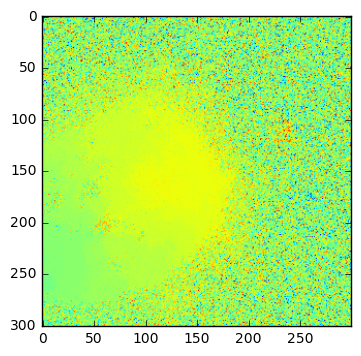

In [71]:
plt.imshow(red_shift_image_n)

In [72]:
red_shift_image_new_n = threshold(red_shift_image_n, 0.0085)

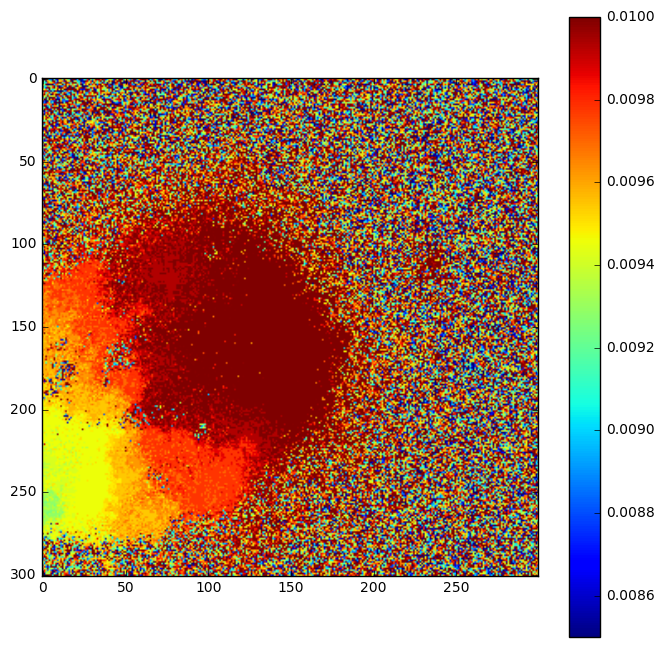

In [73]:
fig, ax = plt.subplots(figsize = (8, 8))
color = ax.imshow(red_shift_image_new_n, clim = (0.0085, 0.01));
fig.colorbar(color)

In [74]:
rs_array_ = red_shift_image_new_n
rs_array_n = rs_array_.flatten()
rs_array_2n = rs_array_n[rs_array_n>0.0085]

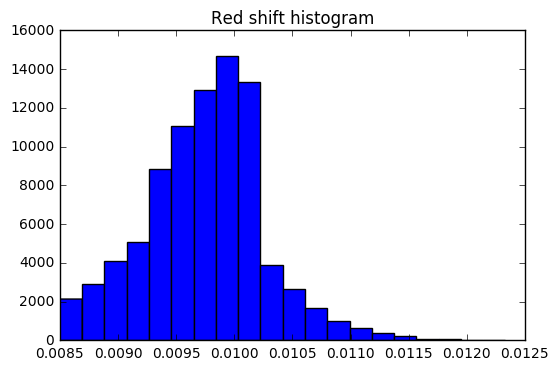

In [75]:
plt.hist(rs_array_2n, bins=20)
plt.title('Red shift histogram');

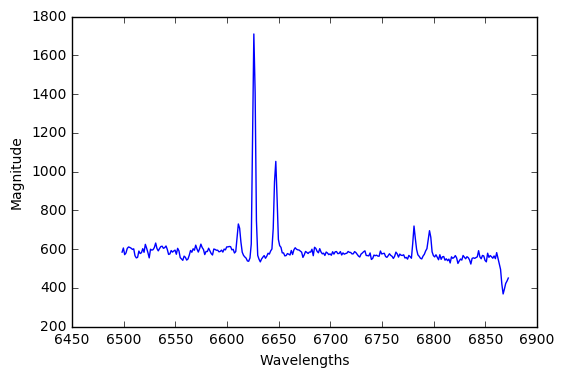

In [327]:
plt.plot(lambdas[1400:1700], filt_image[:, 200, 50][1400:1700])
plt.ylabel('Magnitude')
plt.xlabel('Wavelengths')

In [303]:
clean_spectra = clean_spectra_func(filt_image[:, 50, 250], range_ang=70)

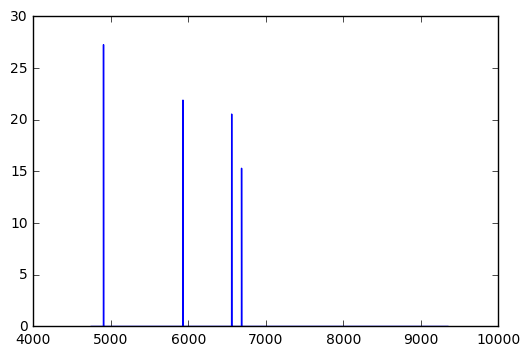

In [304]:
plt.plot(lambdas, clean_spectra)

In [238]:
#Function for template matching
def template_matching(spectra, max_shift=60):
    """
    max_shift: Maximum shift in each direction
    """
    clean_spectra = clean_spectra_func(spectra, range_ang=80)
    possible_values = []
    for var in variables:
        min_bound = np.argmin(np.abs(lambdas - (var-max_shift)))
        max_bound = np.argmin(np.abs(lambdas - (var+max_shift)))
        # Filtering in the bounds
        temp_var = clean_spectra[min_bound:max_bound]
        # Finding the max_value
        max_value_var = np.max(temp_var)
        max_value_arg = np.argmax(temp_var)
        possible_values.append((lambdas[min_bound + max_value_arg] - var)/var)
    return possible_values